#SMART BILLING TEST:

Overview : We use an AI-based approach for retail billing, significantly reducing retail checkout times. Our model accurately detects multiple objects simultaneously, instantly generating bills at the click of a button. Customer satisfaction is vastly improved, leading to better sales, as they no longer need to wait for each item to be manually scanned before the bill is generated.

We use an object detection model based on the Faster RCNN architecture to detect items from an image of the checkout counter.This notebook contains steps to test the object detector.


---



Below is a link to a folder containeing validation data and a trained model : 

https://drive.google.com/drive/folders/10L1PLtX46ANJJ_RafmIREqSmqkeRz6_4?usp=sharing

To use it , please do add it to your drive.


## Installing detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 40.2MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 7.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=21f61f334747461f0ed2022e44ddf9b5db3a3f23c48f369721fb5d3531a6fa8b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-elf5k26x
  Running command git 

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 2.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200319-cp36-none-any.whl size=38927 sha256=7aa7069d3f0cc60b4752499c79069b7f2518c83f9360275d93381e641d4e9415
  Stored in directory: /root/.cache/pip/wheels/da/86/b8/7b74e5131e536cb3d349b2e73b59044569236f494835b16445
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Preparing the dataset

---
We use the Retail Product Checkout dataset([link here](https://rpc-dataset.github.io/#5-Leaderboard)).
Test images and their ground truth annotations in COCO format are contained in `testdata2019` folder and `test.json` file respectively.

In [0]:
# Mounting drive so that the shared folder can be used
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Replace with path to the shared folder in your drive
root_path = "/content/drive/My Drive/TECHNOUTSAV"

In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

#Reading train and test data in COCO format
register_coco_instances("rpc_train", {}, os.path.join(root_path,"train.json"), os.path.join(root_path,"traindata2019"))
register_coco_instances("rpc_test", {}, os.path.join(root_path,"test.json"), os.path.join(root_path,"testdata2019"))

rpc_train_metadata = MetadataCatalog.get("rpc_train")
rpc_test_metadata = MetadataCatalog.get("rpc_test")


**Please note the following cell may give an error. This is because of colab instance timeout due to large number of images in test set. Please try running the cell again or restarting the runtime.**

[03/23 14:30:42 d2.data.datasets.coco]: Loading /content/drive/My Drive/TECHNOUTSAV/test.json takes 1.04 seconds.
[03/23 14:30:42 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json


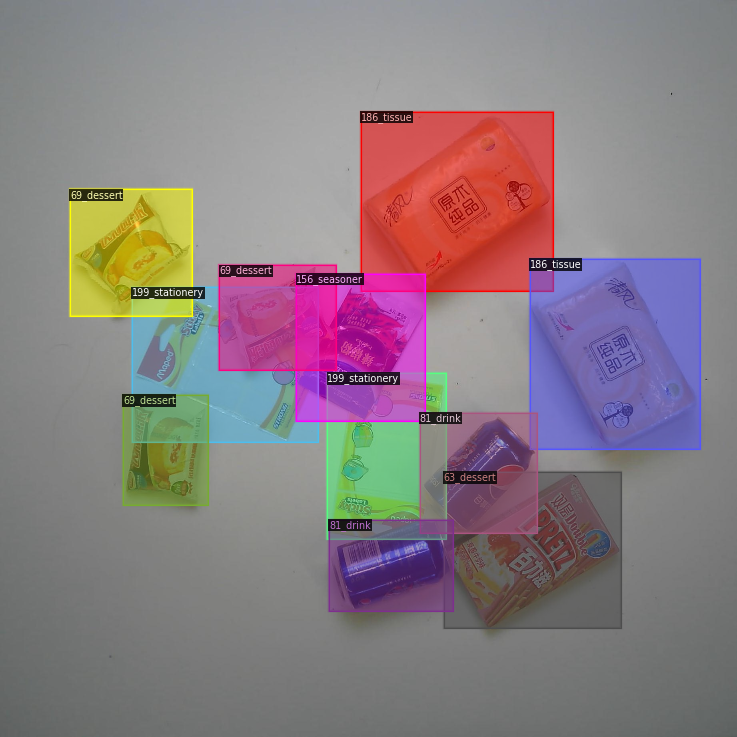

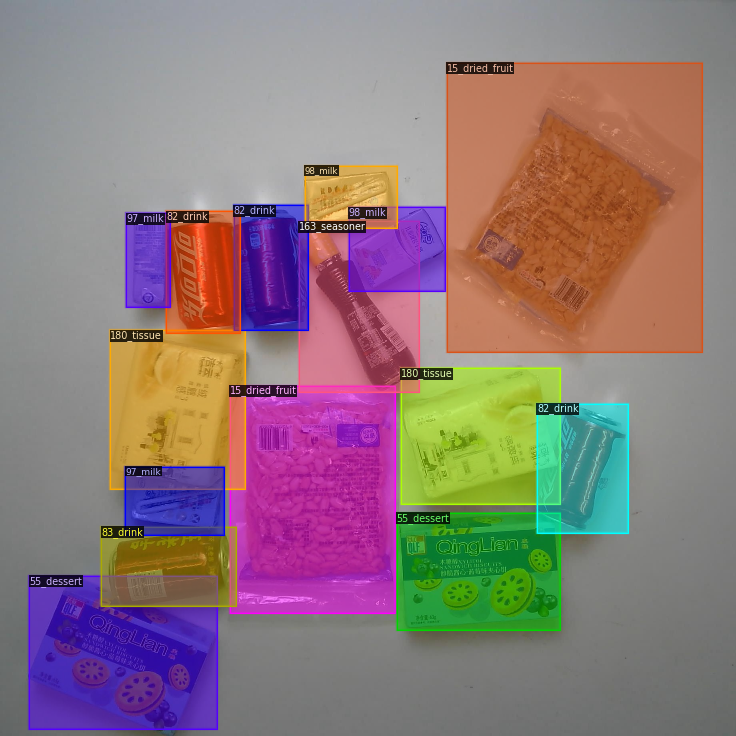

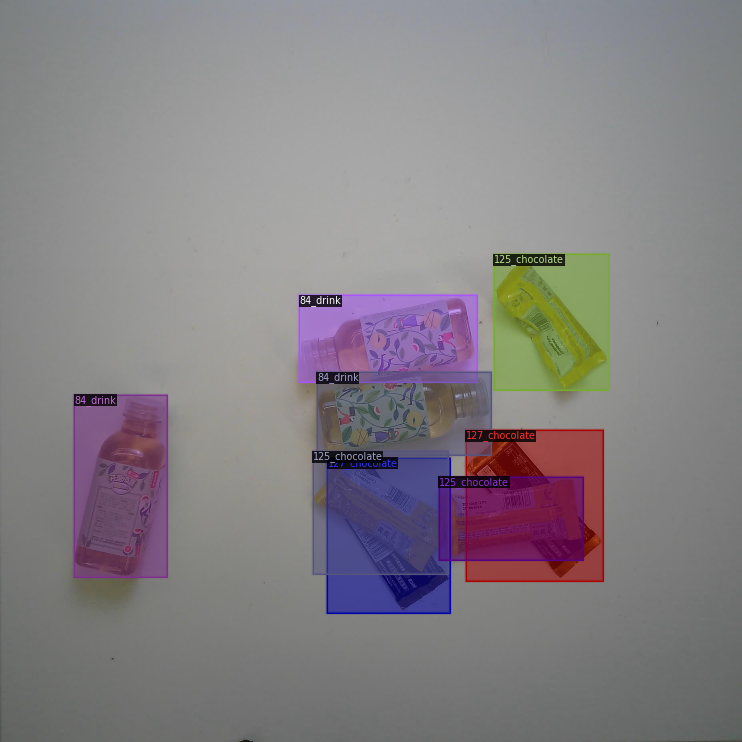

In [0]:
#Visualize 3 samples from the test data
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rpc_test_metadata, scale=0.4)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Testing


---
We provide weights for an object detector trained on the RPC dataset for 5000 epochs. These weights are contained in `smart_billing_model/model_final.pth` in the shared folder.

In [0]:
# Create Default Predictor
from detectron2.engine import DefaultTrainer,DefaultPredictor
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rpc_train",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 200
 

cfg.MODEL.WEIGHTS = os.path.join(root_path,"smart_billing_model/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
cfg.DATASETS.TEST = ("rpc_test", )
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)

[03/18 07:42:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [0]:
# Util function to display list of names of detected items 
product_names = rpc_val_metadata.thing_classes
def create_list(instances):
  det_items = [product_names[i] for i in instances]
  return det_items

[03/23 14:35:17 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20180903-14-34-37-2626.jpg


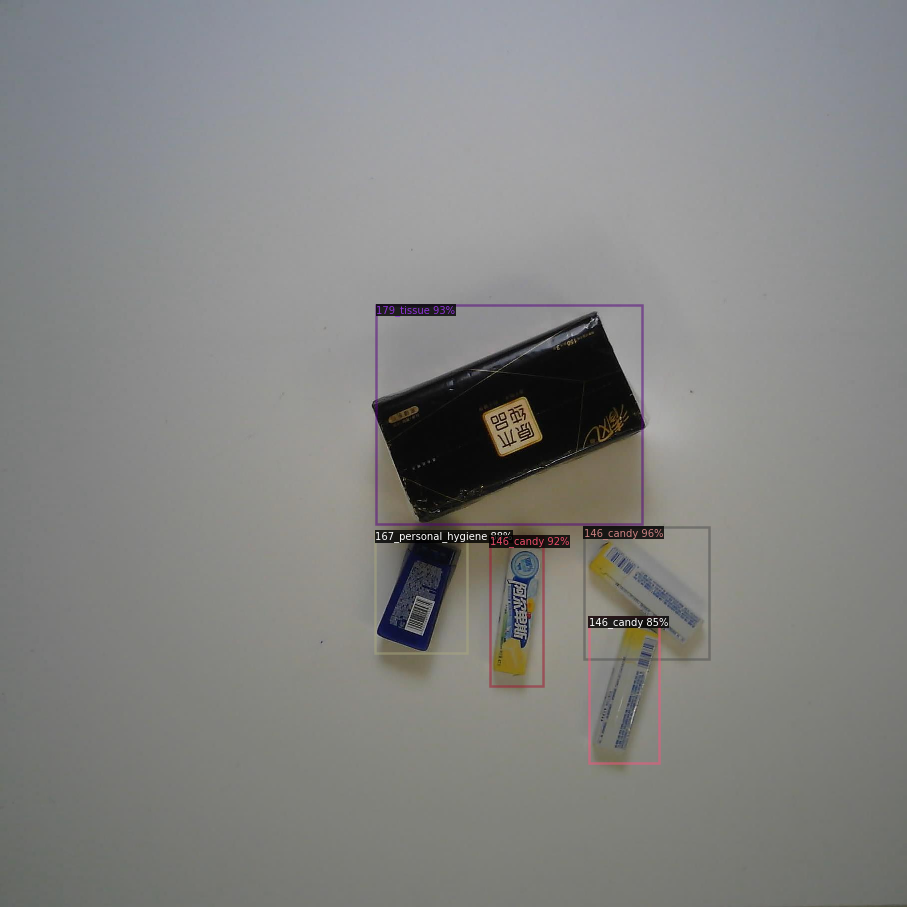

['146_candy', '179_tissue', '146_candy', '167_personal_hygiene', '146_candy']
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20180905-09-42-10-3311.jpg


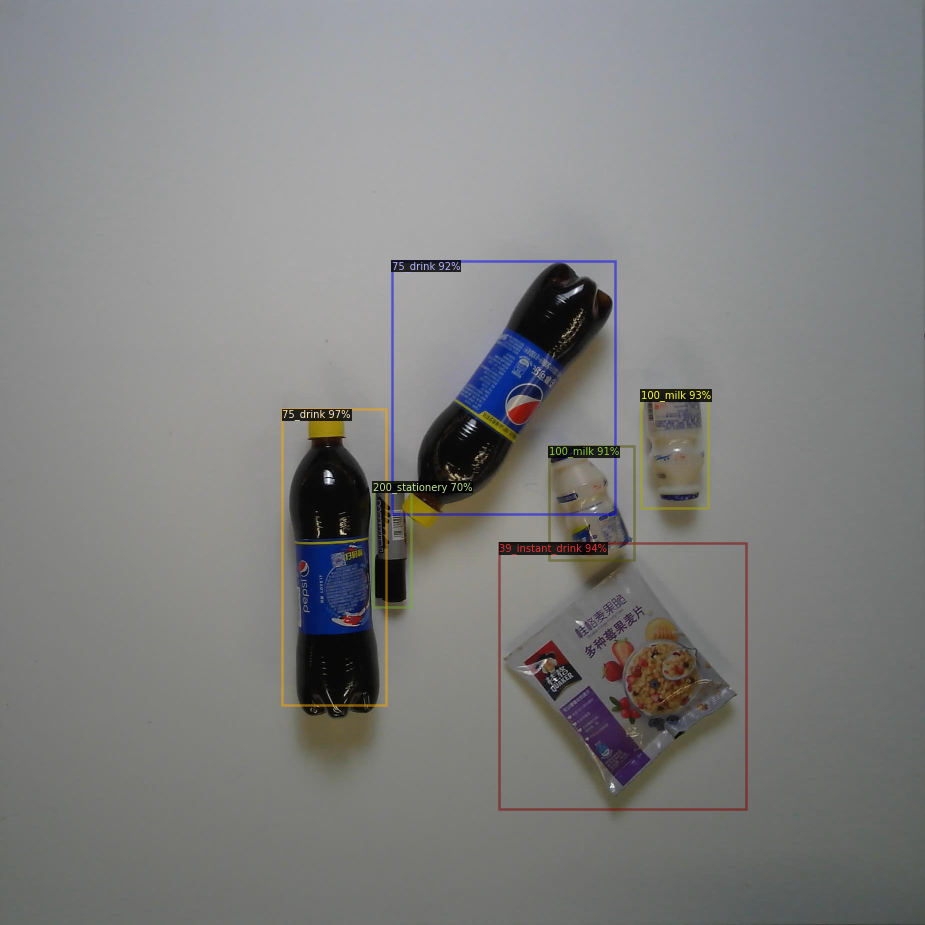

['75_drink', '39_instant_drink', '100_milk', '75_drink', '100_milk', '200_stationery']
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20181022-14-14-49-3226.jpg


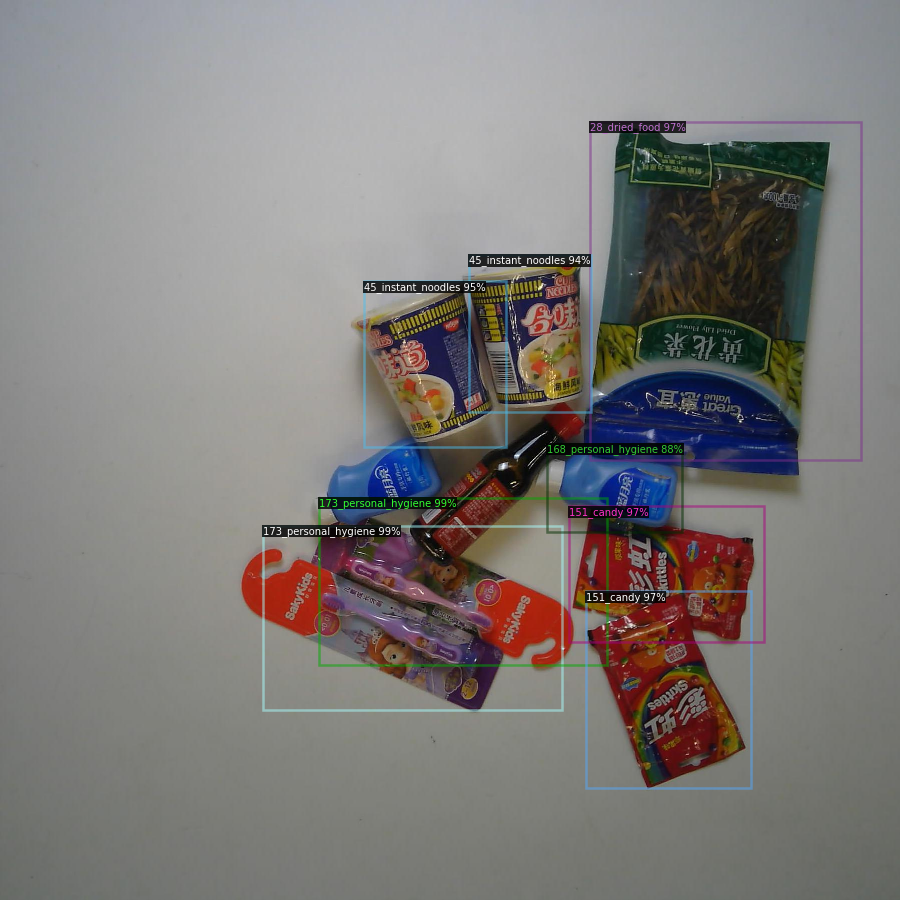

['173_personal_hygiene', '173_personal_hygiene', '151_candy', '28_dried_food', '151_candy', '45_instant_noodles', '45_instant_noodles', '168_personal_hygiene']


In [0]:
# Visualizing detections in images randomly sampled from the test set  
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(d["file_name"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_test_metadata, 
                   scale=0.5, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    items = outputs["instances"].pred_classes.cpu().detach().numpy()
    items = list(items)
    print(create_list(items))

In [0]:
# Running inference on test data, to get test metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("rpc_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "rpc_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/23 14:36:07 d2.data.datasets.coco]: Loading /content/drive/My Drive/TECHNOUTSAV/test.json takes 1.49 seconds.
[03/23 14:36:07 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json
[03/23 14:36:07 d2.data.build]: Distribution of instances among all 200 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| 1_puffed_food | 252          | 2_puffed_food | 421          | 3_puffed_food | 230          |
| 4_puffed_food | 474          | 5_puffed_food | 347          | 6_puffed_food | 433          |
| 7_puffed_food | 465          | 8_puffed_food | 516          | 9_puffed_food | 355          |
| 10_puffed_f.. | 407          | 11_puffed_f.. | 531          | 12_puffed_f.. | 332          |
| 13_dried_fr.. | 331          | 14_dried_fr.. | 317          | 15_dried_fr.. | 418          |
| 16_dried_f

OrderedDict([('bbox',
              {'AP': 63.41137853624544,
               'AP-100_milk': 67.61426785507774,
               'AP-101_milk': 61.24324559159825,
               'AP-102_milk': 72.76807333829439,
               'AP-103_milk': 64.22930227998296,
               'AP-104_milk': 70.42847212337193,
               'AP-105_milk': 67.15403107392346,
               'AP-106_milk': 66.3625295800904,
               'AP-107_milk': 65.83799373981837,
               'AP-108_canned_food': 29.57021919052422,
               'AP-109_canned_food': 70.43569348600863,
               'AP-10_puffed_food': 80.30368380865832,
               'AP-110_canned_food': 80.43704576812625,
               'AP-111_canned_food': 59.074355392360836,
               'AP-112_canned_food': 67.17085972481975,
               'AP-113_canned_food': 74.25263823057074,
               'AP-114_canned_food': 55.93666210204604,
               'AP-115_canned_food': 58.97289955137421,
               'AP-116_canned_food': 71.268